<a href="https://colab.research.google.com/github/iliakabanov/Adherence-to-the-Taylor-Rule-and-Monetary-Policy-Expectations/blob/main/new_rec_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Устанавливаем окружение

In [1]:
# !pip cache purge
# !pip uninstall -y numpy scipy rectools
# !pip install "numpy<1.29.0" "scipy<1.11.0" rectools
# !pip install lightning_fabric
# !pip install rectools
# !pip install rectools[torch]
# !pip install gensim
# !pip install -U sentence-transformers

# Имортируем библиотеки и запускаем spark-сессию

In [2]:
# Get access to Google disk
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Standard library imports
import os
import re
import pickle
import warnings
import textwrap
from pathlib import Path
from collections import Counter
from itertools import chain
from typing import (List, Dict, Optional, Tuple, Union, Any,
                   TypeVar, Callable, Iterable)
from urllib.request import urlopen
from io import BytesIO

# Third-party general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import threadpoolctl

# Machine learning and data processing
from sklearn.preprocessing import (StandardScaler, MultiLabelBinarizer,
                                 normalize)
from sklearn.cluster import (DBSCAN, AgglomerativeClustering)
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from scipy import sparse
from scipy.sparse import hstack, csr_matrix

# Deep learning and NLP
import torch
from sentence_transformers import SentenceTransformer
import timm

# Image processing
from PIL import Image
import requests

# Spark
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_timestamp

# Jupyter specific
from IPython.display import display, Markdown

# Suppress warnings
warnings.filterwarnings("ignore")

In [4]:
# Import libraries
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback

from rectools import Columns, ExternalIds
from rectools.dataset import Dataset
from rectools.metrics import NDCG, Recall, Serendipity, calc_metrics
from rectools.models import BERT4RecModel, SASRecModel, load_model, PopularInCategoryModel
from implicit.cpu.bpr import BayesianPersonalizedRanking
from rectools.models.implicit_bpr import ImplicitBPRWrapperModel
from implicit.cpu.als import AlternatingLeastSquares
from rectools.models.implicit_als import ImplicitALSWrapperModel
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.base import TransformerModelBase

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

warnings.simplefilter("ignore")

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Random seed
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

INFO:lightning_fabric.utilities.seed:Seed set to 60


60

In [5]:
%cd "/content/drive/MyDrive/Colab Notebooks/diploma/scripts/"
import process_data

/content/drive/MyDrive/Colab Notebooks/diploma/scripts


In [6]:
# Создаём SparkSession
spark = SparkSession.builder \
    .appName("PetCo_1") \
    .getOrCreate()

In [7]:
HEAD_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/diploma/'

# Фукнции

In [8]:
def generate_item_text_descriptions(
    catalog: pd.DataFrame,
    text_features: List[str]
) -> pd.DataFrame:
    """Конкатенирует выбранные текстовые признаки товаров через пробел.

    Args:
        catalog: Исходный DataFrame с товарами.
        text_features: Колонки для объединения (в порядке конкатенации).

    Returns:
        DataFrame с одной колонкой 'Text description'.
    """
    text_descriptions = catalog[[text_features[0]]].copy()
    text_descriptions.columns = ['Text description']

    for feature in text_features[1:]:
        text_descriptions['Text description'] += ' ' + catalog[feature].astype(str)

    return text_descriptions

In [9]:
def generate_item_text_embeddings(catalog: pd.DataFrame, text_features: List[str], model: SentenceTransformer, file_to_save: str, save_frequency: int = 1000) -> np.ndarray:
    """Генерирует текстовые эмбеддинги товаров усреднением векторов описаний.

    Args:
        catalog: DataFrame с товарами и их текстовыми признаками
        text_features: Список колонок для формирования описаний
        model: Модель для генерации эмбеддингов
        file_to_save: Путь для промежуточного сохранения результатов
        save_frequency: Частота автосохранения (в количестве товаров)

    Returns:
        Массив эмбеддингов shape=(n_items, embedding_dim)
    """
    item_descriptions = generate_item_text_descriptions(catalog, text_features)
    embeddings = []

    for i in tqdm(range(len(item_descriptions))):
        desc = item_descriptions.iloc[i, 0]
        embeddings.append(model.encode(desc))

        if (i + 1) % save_frequency == 0:
            with open(file_to_save, "wb") as f:
                pickle.dump(np.array(embeddings), f)

    return np.array(embeddings)

In [10]:
def sparse_onehot_from_lists(
    df: pd.DataFrame,
    categorical_columns: List[str]
) -> csr_matrix:
    """Преобразует категориальные столбцы со списками значений в sparse one-hot матрицу.

    Обрабатывает:
    - None/NaN → преобразует в пустые списки
    - Списки значений → one-hot кодирование

    Args:
        df: DataFrame с исходными данными
        categorical_columns: Столбцы для обработки (содержат списки значений)

    Returns:
        Объединённая sparse one-hot матрица в CSR формате
    """
    sparse_matrices = []

    for col in categorical_columns:
        # Обработка пропусков и несписочных значений
        cleaned = df[col].apply(lambda x: x if isinstance(x, list) else [])

        # Sparse one-hot кодирование
        mlb = MultiLabelBinarizer(sparse_output=True)
        sparse_matrices.append(mlb.fit_transform(cleaned))

    return hstack(sparse_matrices, format='csr')

In [11]:
def generate_item_image_embeddings(
    catalog: pd.DataFrame,
    feature: str,
    image_model: timm.models.mobilenetv3.MobileNetV3,
    file_to_save: str
) -> np.ndarray:
    """
    Генерирует эмбеддинги изображений товаров.

    :param catalog: Датасет с товарами. Должен содержать столбец с URL изображений.
    :param feature: Название столбца с URL изображений.
    :param image_model: Предобученная модель для генерации эмбеддингов.
    :param file_to_save: Путь для сохранения промежуточных результатов.
    :return: Массив эмбеддингов изображений shape=(n_items, embedding_dim)
    """
    item_image_embeddings = []
    working_urls = 0

    for i in tqdm(range(len(catalog))):
        image_url = catalog[feature].iloc[i]

        if check_image_url(image_url):
            response = requests.get(image_url, stream=True, timeout=5)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
            if img.mode != 'RGB':
                img = img.convert('RGB')

            output = image_model.forward_features(transforms(img).unsqueeze(0))
            embedding = image_model.forward_head(output, pre_logits=True).detach().numpy()[0, :]
            working_urls += 1
        else:
            embedding = np.zeros(1024)

        item_image_embeddings.append(embedding)

        if i % 1000 == 0:
            with open(file_to_save, "wb") as f:
                pickle.dump(np.array(item_image_embeddings), f)

    return np.array(item_image_embeddings)

In [12]:
def create_user_histories(interactions_df: pd.DataFrame) -> Dict[int, List[int]]:
    """
    Создает словарь историй пользователей на основе взаимодействий с товарами.

    :param interactions_df: Датасет с взаимодействиями пользователей с товарами.
                            Должен содержать столбцы: 'user_id', 'item_id'.
    :return: Словарь {user_id: список товаров, с которыми взаимодействовал пользователь}
    """
    user_histories = {}

    # Группируем данные по user_id и собираем список item_id для каждого пользователя
    for user_id, group in tqdm(interactions_df.groupby('user_id')):
        user_histories[user_id] = group['item_id'].tolist()

    return user_histories

In [13]:
def aggregate_user_cat_embeddings(
    users_histories: Dict[int, List[int]],
    sparse_cat_features: sparse.csr_matrix,
    itemid2index: Dict[int, int]
) -> Tuple[np.ndarray, Dict[int, int]]:
    """
    Агрегирует категориальные признаки товаров в эмбеддинги пользователей.

    :param users_histories: Словарь {user_id: список item_id} с историями просмотров
    :param sparse_cat_features: Sparse-матрица one-hot признаков товаров
    :param itemid2index: Соответствие item_id индексам в sparse_cat_features
    :return: Кортеж (матрица эмбеддингов пользователей, словарь user_id -> индекс)
    """
    num_users = len(users_histories)
    num_features = sparse_cat_features.shape[1]
    user_embeddings = sparse.lil_matrix((num_users, num_features), dtype=np.float32)
    userid2index = {}

    i = 0
    for user_id, item_ids in tqdm(users_histories.items()):
        userid2index[user_id] = i
        indeces = [itemid2index[item_id] for item_id in item_ids if item_id in itemid2index.keys()]
        user_item_features = sparse_cat_features[indeces, :]

        sum_features = user_item_features.sum(axis=0)
        user_embeddings[i] = sum_features
        i += 1

    return user_embeddings.toarray(), userid2index

In [14]:
def aggregate_user_noncat_embeddings(
    user_histories: Dict[int, List[int]],
    item_embeddings: np.ndarray,
    itemid2index: Dict[int, int]
) -> Tuple[np.ndarray, int]:
    """
    Генерирует эмбеддинги пользователей усреднением эмбеддингов товаров из их истории.

    :param user_histories: {user_id: список item_id} - истории взаимодействий
    :param item_embeddings: Массив эмбеддингов товаров shape=(n_items, embedding_dim)
    :param itemid2index: {item_id: индекс} в item_embeddings
    :return: Кортеж (массив эмбеддингов пользователей, количество пропущенных товаров)
    """
    user_embeddings = []
    missed_items = 0

    for user_id, item_ids in tqdm(user_histories.items()):
        item_vectors = []

        for item_id in item_ids:
            if item_id in itemid2index:
                item_vectors.append(item_embeddings[itemid2index[item_id]])
            else:
                missed_items += 1

        if item_vectors:
            user_embeddings.append(np.mean(item_vectors, axis=0))
        else:
            user_embeddings.append(np.zeros(item_embeddings.shape[1]))

    return np.array(user_embeddings), missed_items

In [15]:
def generate_user_embeddings(
    actions: pd.DataFrame,
    catalog: pd.DataFrame,
    text_features: List[str],
    cat_features: List[str],
    image_column: str,
    text_model: object,
    image_model: object
) -> np.ndarray:
    """
    Генерирует объединенные эмбеддинги пользователей на основе их взаимодействий с товарами.
    Комбинирует текстовые, категориальные и визуальные эмбеддинги товаров.

    :param actions: DataFrame с историей взаимодействий пользователей
    :param catalog: DataFrame с каталогом товаров и их признаками
    :param text_features: Список текстовых признаков для генерации эмбеддингов
    :param cat_features: Список категориальных признаков для one-hot кодирования
    :param image_column: Название столбца с URL изображений
    :param text_model: Модель для генерации текстовых эмбеддингов
    :param image_model: Модель для генерации визуальных эмбеддингов
    :return: np.ndarray (объединенные эмбеддинги пользователей)
    """
    # Загрузка предварительно сохраненных эмбеддингов
    item_text_embeddings = pd.read_pickle(HEAD_DIRECTORY+'embeddings/items_names.pkl')
    sparse_item_cat_embeddings = sparse_onehot_from_lists(df=catalog, categorical_columns=cat_features)
    item_image_embeddings = pd.read_pickle(HEAD_DIRECTORY+'embeddings/items_images.pkl')

    # Проверка согласованности данных
    assert item_text_embeddings.shape[0] == sparse_item_cat_embeddings.shape[0] == item_image_embeddings.shape[0]

    # Создание истории пользователей и mapping'ов
    user_histories = create_user_histories(actions)
    itemid2index = {catalog['item_id'].iloc[i]: i for i in range(len(catalog['item_id']))}

    # Генерация отдельных эмбеддингов
    user_text_embeddings, _ = aggregate_user_noncat_embeddings(user_histories, item_text_embeddings, itemid2index)
    user_cat_embeddings, userid2index = aggregate_user_cat_embeddings(user_histories, sparse_item_cat_embeddings, itemid2index)
    user_image_embeddings, _ = aggregate_user_noncat_embeddings(user_histories, item_image_embeddings, itemid2index)

    # Объединение всех эмбеддингов
    user_embeddings = np.hstack((user_text_embeddings, user_cat_embeddings, user_image_embeddings))

    return user_embeddings, userid2index

In [16]:
def tsne(
    vectors: Union[np.ndarray, List[List[float]]],
    perplexity: int = 30,
    random_state: int = 42
) -> np.ndarray:
    """
    Применяет t-SNE для уменьшения размерности векторов до 2D.

    Параметры:
        vectors: Входные векторы (n_samples, n_features)
        perplexity: Параметр perplexity для t-SNE (по умолчанию 30)
        random_state: Seed для воспроизводимости (по умолчанию 42)

    Возвращает:
        Массив формы (n_samples, 2) с проекциями в 2D пространстве
    """
    # Стандартизация данных
    scaler = StandardScaler()
    scaled_vectors = scaler.fit_transform(vectors)

    # Применение t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    return tsne.fit_transform(scaled_vectors)

def visualize_tsne(
    projected_vectors: np.ndarray,
    title: str = 't-SNE visualization',
    figsize: tuple = (10, 8),
    point_size: int = 50
) -> None:
    """
    Визуализирует 2D проекции векторов.

    Параметры:
        projected_vectors: Массив проекций формы (n_samples, 2)
        title: Заголовок графика (по умолчанию 't-SNE visualization')
        figsize: Размер фигуры (по умолчанию (10, 8))
        point_size: Размер точек на графике (по умолчанию 50)
    """
    plt.figure(figsize=figsize)
    sns.scatterplot(
        x=projected_vectors[:, 0],
        y=projected_vectors[:, 1],
        s=point_size
    )

    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
def dbscan_clustering(data, eps=0.5, min_samples=5, tsne_for_high_dim=True):
    """
    Выполняет кластеризацию DBSCAN и визуализирует результаты.

    Параметры:
    - data: numpy array (n_samples, n_features)
    - eps: максимальное расстояние между соседями для DBSCAN
    - min_samples: минимальное количество соседей для core точки
    - visualize: если True, строит график кластеров

    Возвращает:
    - labels: метки кластеров (-1 - выбросы)
    """
    # Стандартизация данных
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Кластеризация DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_data)

    return scaled_data, labels


def visualise_dbscan(scaled_data, labels, eps, min_samples):

    userid2cluster = {}
    for user_id, index in userid2index.items():
      userid2cluster[user_id] = labels[index]

    plt.figure(figsize=(10, 8))

    vis_data = scaled_data[:, :2]
    x_label, y_label = 't-SNE dimension 1', 't-SNE dimension 2'

    # Визуализация
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'gray'  # Выбросы серым

        class_member_mask = (labels == k)
        xy = vis_data[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, label=f'Cluster {k}' if k != -1 else 'Outliers')

    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

    return userid2cluster

In [18]:
def show_image_from_url(url):
    """
    Проверяет существование изображения по URL и выводит его на экран.

    Параметры:
        url (str): Ссылка на изображение в интернете.

    Возвращает:
        bool: True если изображение существует и отображено, иначе False.
    """
    try:
        # Загружаем изображение с проверкой HTTP-статуса
        response = requests.get(url, stream=True, timeout=5)
        response.raise_for_status()  # Проверяет на ошибки HTTP (404, 403 и т.д.)

        # Проверяем, что это действительно изображение
        if 'image' not in response.headers['Content-Type']:
            print("⚠️ URL не ведет к изображению (Content-Type:", response.headers['Content-Type'], ")")
            return False

        # Преобразуем байты в изображение и выводим
        img = Image.open(BytesIO(response.content))

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')  # Скрываем оси
        plt.title(f"Изображение из URL:\n{url[:50]}...", fontsize=10)
        plt.show()
        return img

    except requests.exceptions.RequestException as e:
        print(f"❌ Ошибка при загрузке изображения: {e}")
        return False
    except Exception as e:
        print(f"⚠️ Неожиданная ошибка: {e}")
        return False

In [19]:
def check_image_url(url):
    """Проверяет, доступно ли изображение по URL."""
    try:
        response = requests.head(url, timeout=5, allow_redirects=True)
        if response.status_code == 200 and 'image' in response.headers.get('Content-Type', ''):
            return True
        return False
    except:
        return False

In [20]:
def get_user_histories_by_cluster(
    cluster: int,
    clusters: Dict[int, int],
    interactions_with_features: pd.DataFrame,
    n_examples: int = 3
) -> None:
    """
    Выводит примеры пользовательских историй для заданного кластера.

    Параметры:
        cluster: Номер кластера для отображения примеров
        clusters: Словарь {user_id: cluster_label} с принадлежностью к кластерам
        interactions_with_features: DataFrame с историей взаимодействий пользователей
        n_examples: Количество примеров для отображения (по умолчанию 3)

    Возвращает:
        None (функция только выводит информацию на экран)
    """
    n_printed_examples = 0

    for user_id, user_cluster in clusters.items():
        if user_cluster == cluster:
            display(Markdown(f"**<font size='+2'>user {user_id} conversions from cluster {user_cluster}</font>**"))
            display_user_actions(
                user_id=user_id,
                df=interactions_with_features,
                n_cols=10,
                show_text=True
            )
            n_printed_examples += 1

            if n_printed_examples >= n_examples:
                break

In [21]:
def display_user_actions(
    user_id: int,
    df: pd.DataFrame,
    n_cols: int = 5,
    cell_width: float = 2.5,
    cell_height: float = 3,
    show_text: bool = True,
    fontsize: int = 8,
    max_name_length: int = 20,
    timeout: float = 3.0,
    image_url_column: str = 'image_url',
    item_id_column: str = 'item_id',
    name_column: str = 'name'
) -> None:
    """
    Визуализирует действия пользователя с фиксированным размером ячеек.

    Параметры:
        user_id: ID пользователя для отображения
        df: DataFrame с данными о взаимодействиях
        n_cols: Количество колонок в сетке (по умолчанию 5)
        cell_width: Ширина ячейки в дюймах (по умолчанию 2.5)
        cell_height: Высота ячейки в дюймах (по умолчанию 3)
        show_text: Показывать текстовую информацию (по умолчанию True)
        fontsize: Размер шрифта (по умолчанию 8)
        max_name_length: Максимальная длина строки названия (по умолчанию 20)
        timeout: Таймаут загрузки изображения в секундах (по умолчанию 3.0)
        image_url_column: Название колонки с URL изображений (по умолчанию 'image_url')
        item_id_column: Название колонки с ID товаров (по умолчанию 'item_id')
        name_column: Название колонки с именами товаров (по умолчанию 'name')
    """
    user_items = df[df['user_id'] == user_id]
    if user_items.empty:
        print(f"Пользователь {user_id} не найден.")
        return

    n_items = len(user_items)
    n_rows = int(np.ceil(n_items / n_cols))
    figsize = (n_cols * cell_width, n_rows * cell_height)
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(n_rows, n_cols, wspace=0.1, hspace=0.2)

    for idx, (_, row) in enumerate(user_items.iterrows()):
        ax = fig.add_subplot(grid[idx // n_cols, idx % n_cols])

        try:
            # Загрузка и обработка изображения
            response = requests.get(row[image_url_column], timeout=timeout)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))

            # Масштабирование с сохранением пропорций
            img_aspect = img.size[0] / img.size[1]
            display_width = min(cell_width * 0.9, cell_height * 0.8 * img_aspect)
            display_height = display_width / img_aspect

            ax.imshow(img, extent=[
                (cell_width - display_width)/2,
                (cell_width + display_width)/2,
                (cell_height - display_height)/2,
                (cell_height + display_height)/2
            ])

            if show_text:
                name = '\n'.join(textwrap.wrap(row[name_column], max_name_length))
                ax.text(
                    cell_width/2, -0.2*cell_height,
                    f"ID: {row[item_id_column]}\n{name}",
                    ha='center', va='top',
                    fontsize=fontsize, wrap=True
                )

        except Exception as e:
            # Обработка ошибок загрузки изображения
            ax.add_patch(plt.Rectangle(
                (0, 0), cell_width, cell_height,
                color='lightgray'
            ))
            if show_text:
                ax.text(
                    cell_width/2, cell_height/2, 'X',
                    color='red', ha='center', va='center'
                )
                ax.text(
                    cell_width/2, -0.2*cell_height,
                    f"ID: {row[item_id_column]}",
                    ha='center', va='top', fontsize=fontsize
                )

        ax.set_xlim(0, cell_width)
        ax.set_ylim(-0.3*cell_height if show_text else 0, cell_height)
        ax.axis('off')

    # Скрытие пустых ячеек
    for idx in range(n_items, n_rows * n_cols):
        fig.add_subplot(grid[idx // n_cols, idx % n_cols]).axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
class PopularInUserModel():
    def __init__(self, k: int = 10):
        """
        Рекомендательная система на основе популярности.
        :param top_n: Количество рекомендаций на пользователя
        """
        self.top_n = k
        self.item_popularity = None
        self.user_top_items = None

    def fit(self, interactions: pd.DataFrame):
        """
        Обучает модель на данных о взаимодействиях пользователей с товарами.
        :param interactions: DataFrame с колонками ['user_id', 'item_id']
        """
        # Подсчет популярности товаров
        item_counts = interactions['item_id'].value_counts().reset_index()
        item_counts.columns = ['item_id', 'score']
        self.item_popularity = item_counts

        # Топ-10 популярных товаров для каждого пользователя
        user_top_items = (
            interactions.groupby('user_id')['item_id']
            .value_counts()
            .reset_index(name='score')
        )

        self.user_top_items = user_top_items[user_top_items.groupby('user_id').cumcount() < self.top_n]

    def recommend(self, user_ids: List[int], train_dataset = None, k = None, filter_viewed = None) -> pd.DataFrame:
        """
        Возвращает DataFrame с рекомендациями в формате user_id, item_id, score, rank.
        :param user_ids: Список ID пользователей
        :return: DataFrame с рекомендациями
        """
        if self.user_top_items is None or self.item_popularity is None:
            raise ValueError("Модель не обучена. Вызовите .fit() перед рекомендациями.")

        recommendations = []
        for user_id in user_ids:
            user_items = self.user_top_items[self.user_top_items['user_id'] == user_id].sort_values(by='score', ascending=False)

            # Дополняем недостающие рекомендации самыми популярными товарами
            if len(user_items) < self.top_n:
                additional_items = self.item_popularity[~self.item_popularity['item_id'].isin(user_items['item_id'])]
                additional_items = additional_items.head(self.top_n - len(user_items)).copy().sort_values(by='score', ascending=False)
                additional_items['user_id'] = user_id
                user_items = pd.concat([user_items, additional_items], ignore_index=True)

            user_items = user_items.head(self.top_n)
            user_items['rank'] = range(1, len(user_items) + 1)
            recommendations.append(user_items)

        return pd.concat(recommendations, ignore_index=True)[['user_id', 'item_id', 'score', 'rank']]

In [23]:
def keep_top_10_clusters(labels):
    """
    Оставляет только 10 самых многочисленных кластеров, остальные помечает как шум (-1).

    Параметры:
    - labels: массив с метками кластеров (например, результат DBSCAN)

    Возвращает:
    - Модифицированный массив меток, где только 10 самых больших кластеров сохранили свои номера,
      а остальным присвоено -1
    """
    # Считаем количество точек в каждом кластере (исключая шум -1)
    cluster_counts = Counter(labels)
    if -1 in cluster_counts:
        del cluster_counts[-1]  # Игнорируем точки шума

    # Если кластеров 10 или меньше - ничего не меняем
    if len(cluster_counts) <= 10:
        return labels.copy()

    # Находим 10 самых больших кластеров
    top_10_clusters = [cluster for cluster, _ in cluster_counts.most_common(10)]

    # Создаем новый массив меток
    new_labels = np.full_like(labels, -1)  # По умолчанию - шум

    # Сохраняем только топ-10 кластеров
    for cluster in top_10_clusters:
        new_labels[labels == cluster] = cluster

    return new_labels

In [24]:
def get_cluster_examples(userid2clusters: Dict[int, int]):
  cluster_examples = {}
  for cluster in np.unique(list(userid2clusters.values()))[1:]:
    for user_id, user_cluster in userid2clusters.items():
      if user_cluster == cluster:
        cluster_examples[cluster] = user_id
        break

  return cluster_examples

# Данные


In [25]:
# sasrec_data_folder_path = HEAD_DIRECTORY+'data/sasrec_format/'
# output_name = 'actions'
# data_actions_processed = spark.read.parquet(sasrec_data_folder_path+output_name).orderBy(['user_id', 'datetime'])

In [26]:
# sasrec_data_folder_path = HEAD_DIRECTORY+'data/sasrec_format/'
# output_name = 'items'
# data_items_processed = spark.read.parquet(sasrec_data_folder_path+output_name).orderBy('id', 'feature', 'value')
# data_items_cleaned = spark.read.parquet(HEAD_DIRECTORY+'data/cleaned_data/data_items')

In [27]:
# actions, items_features = process_data.processed_datasets_to_pandas(data_actions_processed, data_items_processed)
# actions.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/actions.pkl')
# items_features.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/items.pkl')
actions = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/actions.pkl')
items = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/items.pkl')

In [28]:
# catalog = data_items_cleaned.select('customer_id', 'name', 'group_ids_intersect', 'How_to_get_it', 'Primary_Brand', 'Primary_Pet_Type', 'image_url').toPandas()
# catalog.rename(columns={'customer_id': 'item_id'}, inplace=True)
# catalog['item_id'] = catalog['item_id'].apply(lambda x: int(x))
# catalog = catalog.rename(columns={'group_ids_intersect': 'Category', 'How_to_get_it': 'Delivery', 'Primary_Brand': 'Brand', 'Primary_Pet_Type': 'Pet'})
# catalog['Pet'] = catalog['Pet'].apply(lambda x: x[0].split(',') if x else x)
# catalog.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/catalog.pkl')
catalog = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/catalog.pkl')
actions_with_item_features = actions.merge(catalog, on='item_id', how='left')

In [29]:
# В валлидационный датасет откладываем последнее действие для каждого юзера
val_df = actions.loc[actions.groupby("user_id")["datetime"].idxmax()]

# Обучающий датасет – все, кроме последней итерации у каждого пользователя
train_df = actions.drop(val_df.index)
train_df_with_features = train_df.merge(catalog, on='item_id', how='left')

# Кластеризация юзеров по их историям конверсий

In [30]:
# Загружаем текстовую модель
text_model = SentenceTransformer('nfhakim/topic-clustering-v1')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
# Загружаем модель для создания эмбеддингов картинок
image_model = timm.create_model(
    'mobilenetv3_small_100.lamb_in1k',
    pretrained=True
)
image_model = image_model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(image_model)
transforms = timm.data.create_transform(**data_config, is_training=False)

model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

In [32]:
# Создаем эмбеддинги юзеров по историям их конверсий
user_embeddings, userid2index = generate_user_embeddings(actions=actions,
                                                         catalog=catalog,
                                                         text_features=['name'],
                                                         cat_features=['Category', 'Delivery', 'Brand', 'Pet'],
                                                         image_column='image_url',
                                                         text_model=text_model,
                                                         image_model=image_model)
user_embeddings.shape

100%|██████████| 19688/19688 [00:02<00:00, 8150.40it/s] 


(19688, 4090)

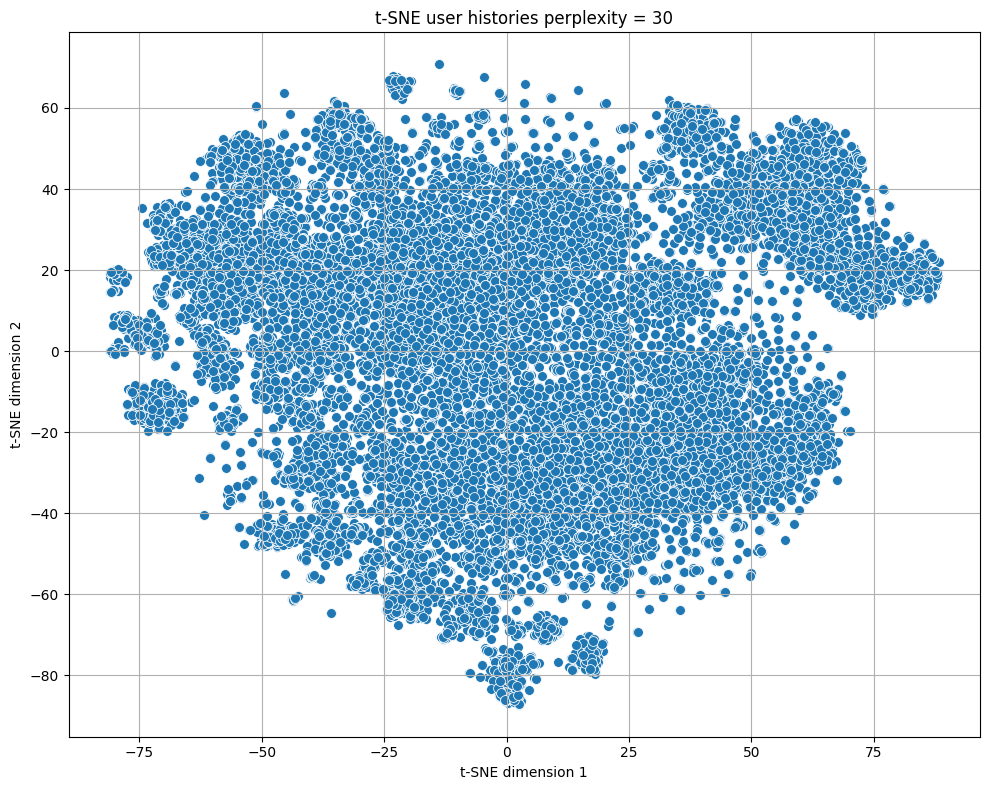

In [38]:
# Проектируем эмеддинги на плоскость и визуализируем их

# projected_vectors = tsne(user_embeddings, perplexity=30)
# with open(HEAD_DIRECTORY+'embeddings/users_tsne_text_cat_image.pkl', "wb") as f:
#   pickle.dump(projected_vectors, f)
projected_vectors = pd.read_pickle(HEAD_DIRECTORY+'embeddings/users_tsne_2d_text_cat_image.pkl')
visualize_tsne(projected_vectors, title='t-SNE user histories perplexity = 30')

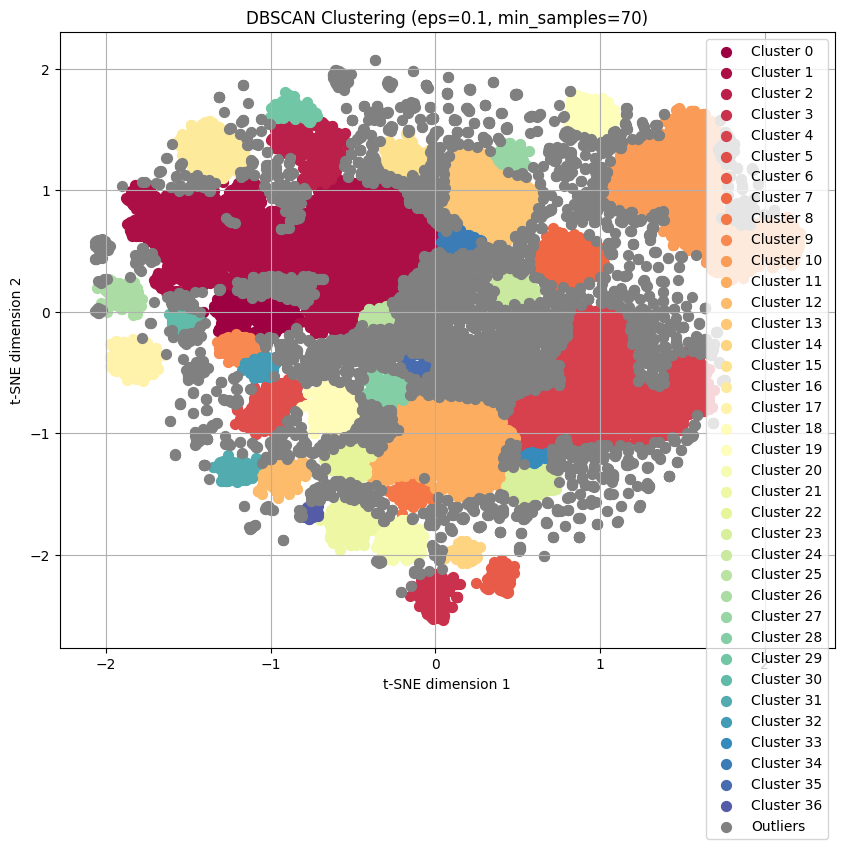

In [39]:
# Кластеризуем юзеров с помощью DBSCAN
scaled_vectors, labels = dbscan_clustering(projected_vectors, eps=0.1, min_samples=70)
userid2cluster = visualise_dbscan(scaled_vectors, labels, 0.1, 70)

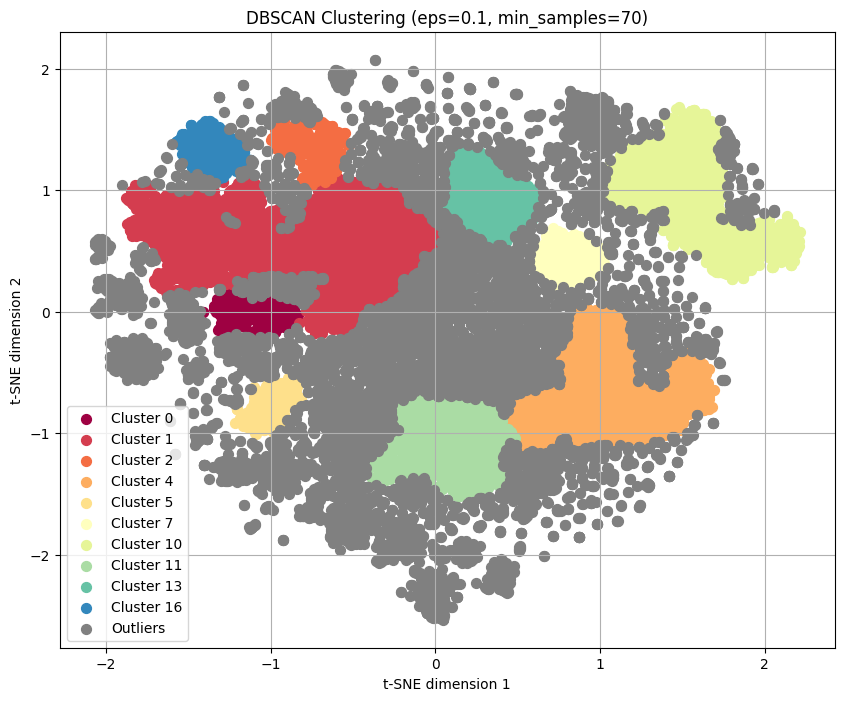

In [40]:
# Оставляем только 10 самых крупных кластеров
userid2cluster = visualise_dbscan(scaled_vectors, keep_top_10_clusters(labels), 0.1, 70)

**<font size='+2'>user 154695 conversions from cluster 1</font>**

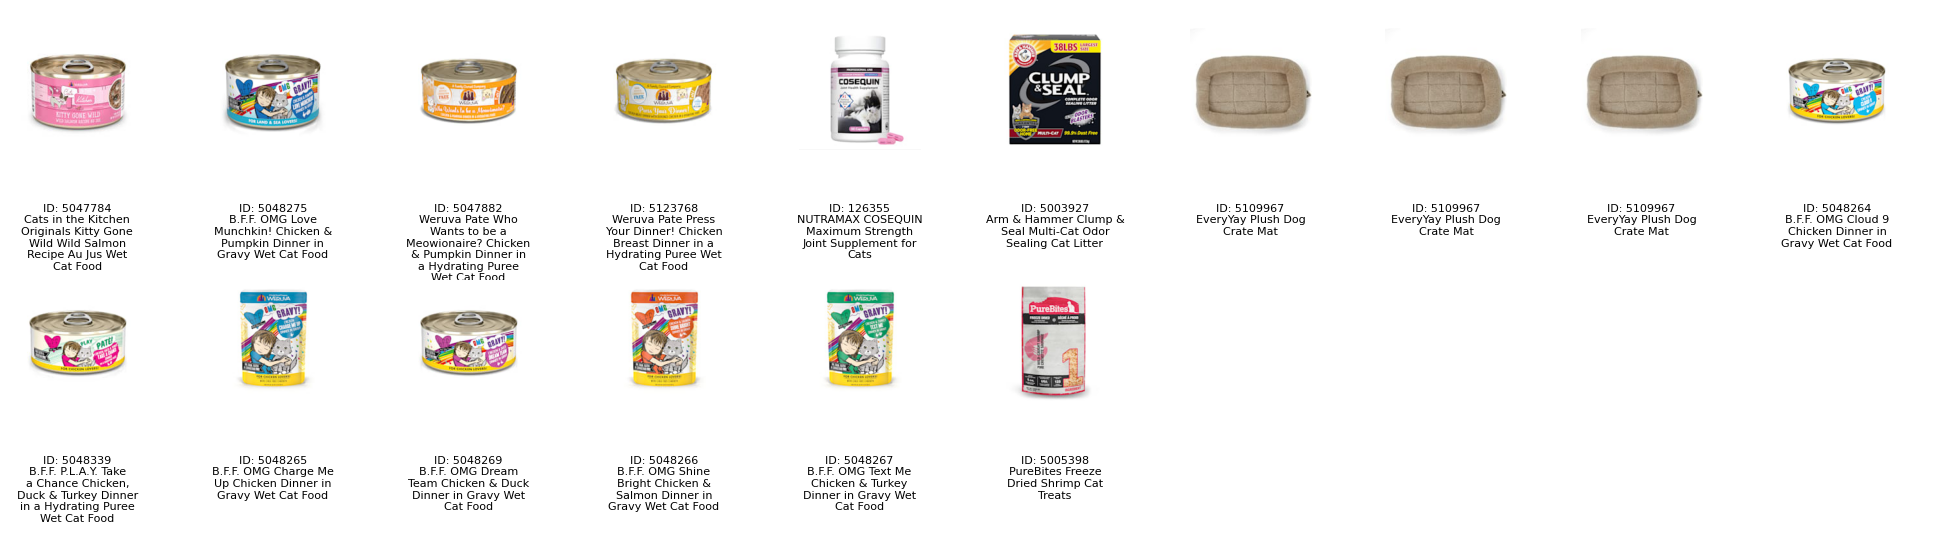

**<font size='+2'>user 162384 conversions from cluster 1</font>**

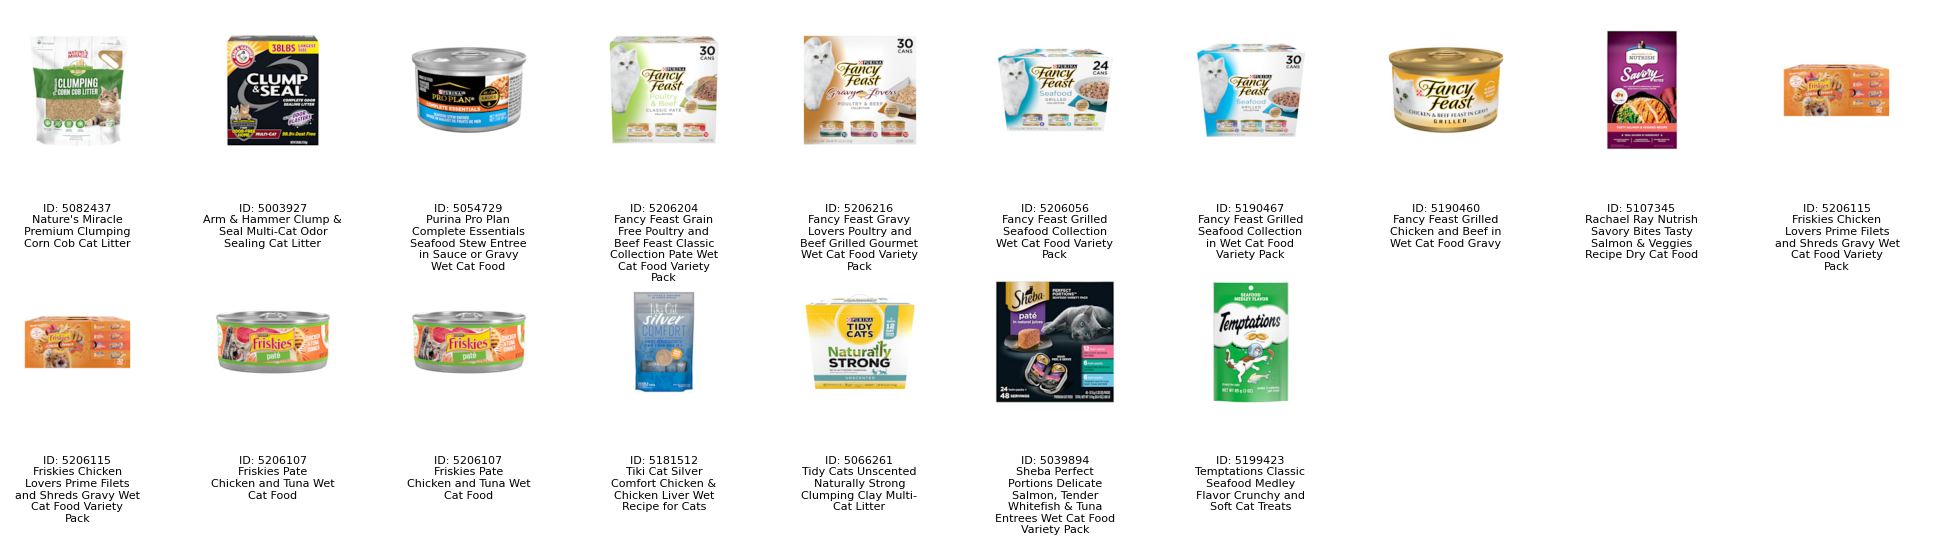

**<font size='+2'>user 167173 conversions from cluster 1</font>**

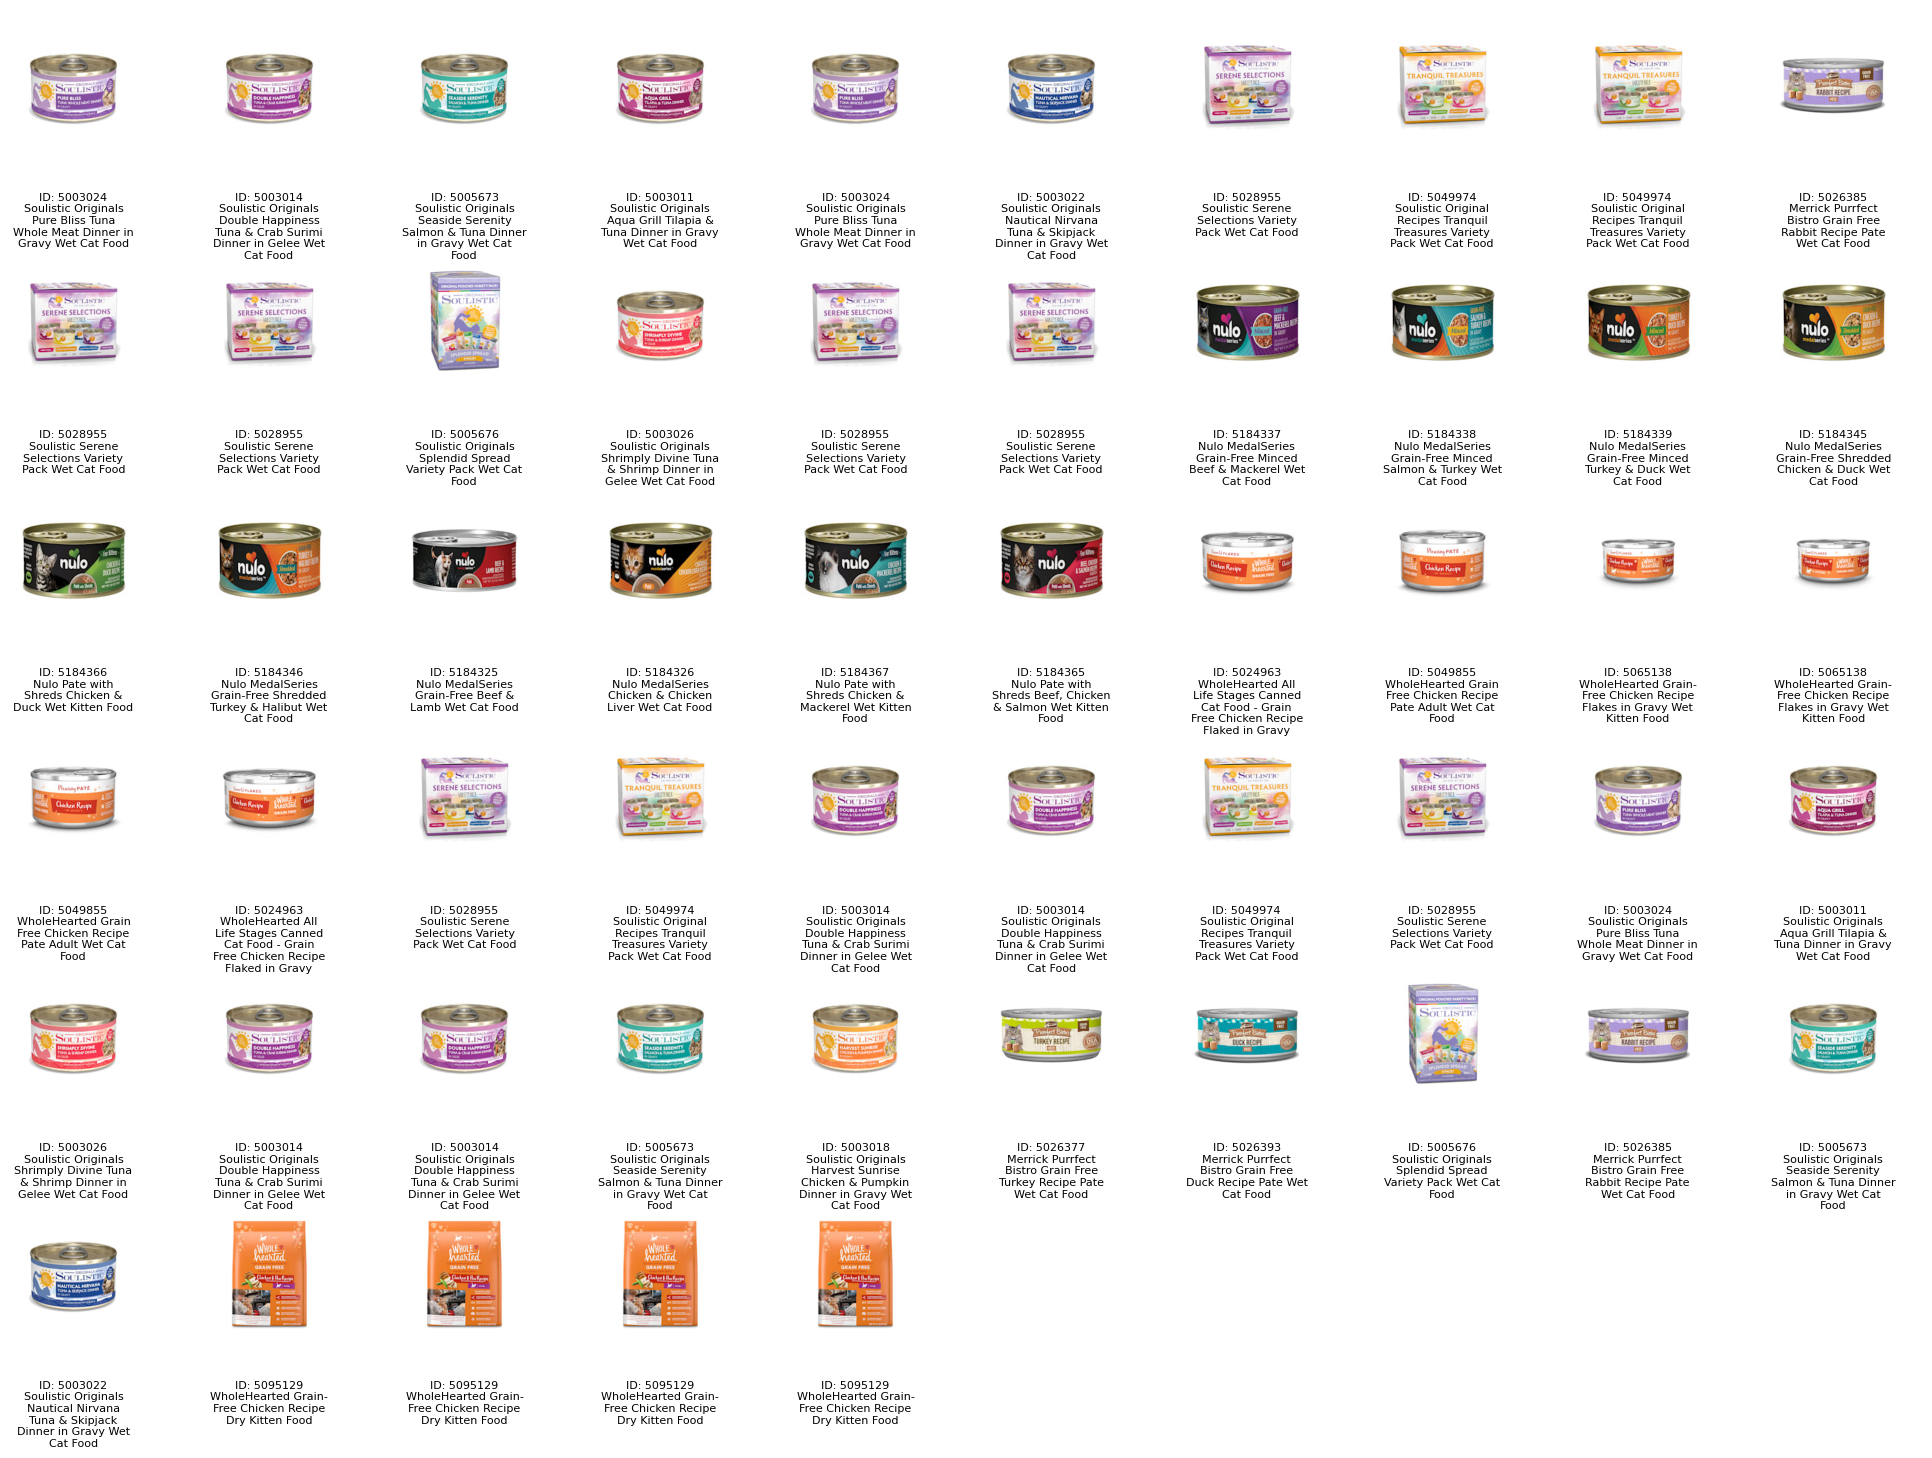

In [41]:
# Смотрим на однородность кластера
get_user_histories_by_cluster(cluster=1, clusters=userid2cluster, interactions_with_features=actions_with_item_features, n_examples=3)

In [42]:
#Получаем по одному примеру из каждого кластера
cluster_examples = get_cluster_examples(userid2clusters=userid2cluster)
cluster_examples

{0: 146163,
 1: 154695,
 2: 768726,
 4: 2378,
 5: 1056925,
 7: 1485739,
 10: 733322,
 11: 806550,
 13: 237492,
 16: 875393}